In [1]:
import pandahouse
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu

rng = np.random.default_rng()

### AA test

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20241020',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
q = """
select 
   user_id,
   exp_group,
   sum(action='view') as views,
   sum(action='like') as likes,
   likes/views as ctr 
from simulator_20241020.feed_actions
where toDate(time) between '2024-12-27' and '2025-01-02' and exp_group in (2,3)
group by user_id, exp_group
"""

In [4]:
df=pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,views,likes,ctr
0,78186,2,74,16,0.216216
1,115383,3,28,5,0.178571
2,10326,3,13,2,0.153846
3,131473,2,65,8,0.123077
4,36785,3,29,6,0.206897


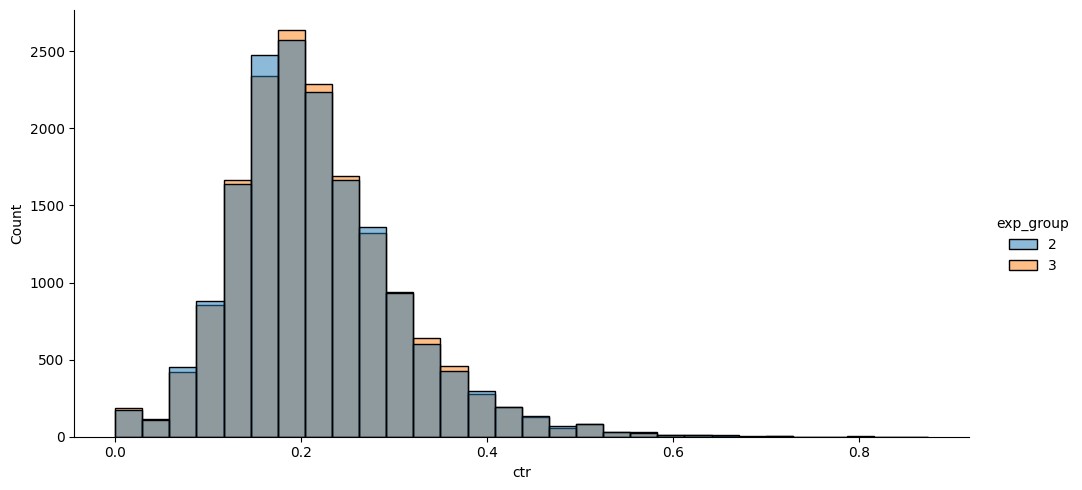

In [5]:
sns.displot(data=df, x='ctr', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [8]:
samples = 500
n_tests = 10000
p_values=[]
for i in range(n_tests):
    group_a1=df[df['exp_group']==2].ctr.sample(samples, replace=True)
    group_a2=df[df['exp_group']==3].ctr.sample(samples, replace=True)
    p_value=ttest_ind(group_a1,group_a2, equal_var=False)[1]
    p_values.append(p_value)

<Axes: ylabel='Count'>

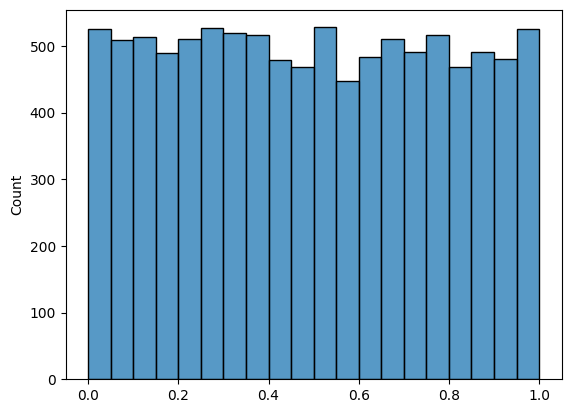

In [9]:
sns.histplot(p_values,bins=20,  kde=False)

In [10]:
sum(np.array(p_values) < 0.05) / n_tests

0.0524

The distribution of the resulting p-values is approximately uniform.The proportion of p-values below the significance threshold is approximately 0.046.his is approximately what
was expected. This means that the splitting system works correctly

### AB test

There will be an investigation of data on users who participated in A/B testing, which took place from 2025-01-03  to 2025-01-09, inclusive. Groups 2 and 1 were involved in the experiment.
**Group 2** used one of the new post recommendation algorithms (), while **group 1** was used as a control. The main hypothesis is that the new algorithm in group 2 will lead to an increase in CTR.

In [56]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250120',
'user':'student',
'password':'dpo_python_2020'
}

In [58]:
q = """
select 
   user_id,
   exp_group,
   sum(action='like')/sum(action='view') as ctr 
from simulator_20250120.feed_actions 
where toDate(time) between '2025-01-03' and '2025-01-09' and exp_group in (1,2)
group by user_id, exp_group
"""

In [59]:
df=pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,ctr
0,109963,1,0.200000
1,26117,1,0.226950
2,138232,1,0.246575
3,26295,1,0.276596
4,18392,1,0.218750


In [60]:
df.groupby('exp_group').count()

,user_id,ctr
exp_group,,
1,10020,10020
2,9877,9877


In [61]:
df.groupby('exp_group').ctr.mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

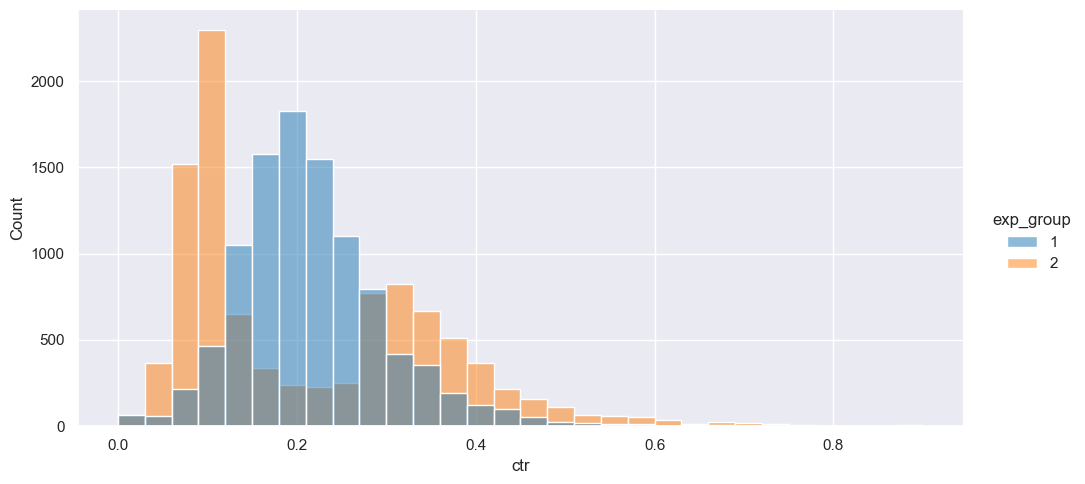

In [62]:
sns.displot(data=df, x='ctr', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [63]:
print(stats.mannwhitneyu(df[df['exp_group']==1].ctr, df[df['exp_group']==2].ctr))

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)


There is a statistically significant difference in CTR between experimental groups 1 and 2.
The bimodality of the distribution tells us that there is a group of users who have been positively affected by the new algorithm and a group of users who have been negatively affected by it.